In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 48.7 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=e6b091ebcfabd4d75d198844eab88a8863ed23b7bdfbe99bcec2c795ad9e4dee
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=eb037e60101ff405bbb37069bcb7dfdb50862bd93d8ce8fc14a826b3e086e7b7
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel f

# 影片轉tensor

In [3]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import center_crop

# === 設定 ===
video_dir = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S"
save_dir = os.path.join(video_dir, "tensors_x3d")
os.makedirs(save_dir, exist_ok=True)

# === 前處理參數 ===
NUM_FRAMES = 13
RESIZE_SIZE = 160
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
])

# === 影片 → Tensor 函數 ===
def video_to_tensor(video_path, num_frames=NUM_FRAMES, size=RESIZE_SIZE):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frame = center_crop(frame, size)
        frame = frame.resize((size, size))  # (H, W)
        frames.append(transform(frame))  # → (C, H, W)

    cap.release()
    if len(frames) != num_frames:
        return None  # 忽略長度不足的影片

    video_tensor = torch.stack(frames, dim=1)  # (C, T, H, W)
    return video_tensor
'''
# === 批次處理所有影片 ===
video_list = sorted([f for f in os.listdir(video_dir) if f.endswith(".mp4")])
for video_file in tqdm(video_list, desc="Processing videos"):
    video_path = os.path.join(video_dir, video_file)
    tensor = video_to_tensor(video_path)
    if tensor is not None:
        save_path = os.path.join(save_dir, video_file.replace(".mp4", ".pt"))
        torch.save(tensor, save_path)
'''

'\n# === 批次處理所有影片 ===\nvideo_list = sorted([f for f in os.listdir(video_dir) if f.endswith(".mp4")])\nfor video_file in tqdm(video_list, desc="Processing videos"):\n    video_path = os.path.join(video_dir, video_file)\n    tensor = video_to_tensor(video_path)\n    if tensor is not None:\n        save_path = os.path.join(save_dir, video_file.replace(".mp4", ".pt"))\n        torch.save(tensor, save_path)\n'

# 整理成X,Y

In [4]:
import os
import torch
import pandas as pd
from tqdm import tqdm

# === 路徑設定 ===
tensor_dir = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S/tensors_x3d"
csv_path = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S/Milwaukee_Brewers_FF.csv"

# === 讀取 CSV：建立 filename → description 的對應字典 ===
df = pd.read_csv(csv_path)
label_dict = dict(zip(df["Filename"], df["description"]))  # e.g., {"pitch_0001.mp4": "strike"}

# === 讀取所有 .pt 檔案，並對應回 label ===
X = []
y = []

tensor_files = sorted([f for f in os.listdir(tensor_dir) if f.endswith(".pt")])
for pt_file in tqdm(tensor_files, desc="Loading tensors"):
    mp4_filename = pt_file.replace(".pt", ".mp4")

    if mp4_filename not in label_dict:
        print(f"⚠️ {mp4_filename} not found in CSV, skipping.")
        continue

    tensor_path = os.path.join(tensor_dir, pt_file)
    video_tensor = torch.load(tensor_path)  # (3, T, H, W)

    label = label_dict[mp4_filename]

    X.append(video_tensor)
    y.append(label)  # or use label_map[label] if you want to map to integers

print(f"✅ Loaded {len(X)} samples")


Loading tensors: 100%|██████████| 382/382 [00:38<00:00,  9.95it/s]

✅ Loaded 382 samples


# 將y做encoding

In [5]:
y = [1 if ("strike" in label.lower() or "foul" in label.lower()) else 0 for label in y]

In [10]:
X_list = X
y_list = y

# supcon loss

In [12]:
# === 1. Import ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorchvideo.models.hub import x3d_xs
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

# === 2. 固定種子 ===
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all()

# === 3. Dataset（假設你已經轉成 Tensor）===
class SimpleVideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # list of [3, 13, 160, 160]
        self.y = y  # list of int

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# === 4. SupCon Loss ===
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        features = F.normalize(features, dim=1)
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_mask = ~torch.eye(labels.shape[0], dtype=torch.bool).to(device)
        mask = mask * logits_mask

        exp_sim = torch.exp(similarity_matrix) * logits_mask
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-12)
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
        loss = -mean_log_prob_pos.mean()
        return loss

# === 5. 模型架構 ===
class SupConModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = x3d_xs(pretrained=True)
        self.encoder.blocks[-1].proj = nn.Identity()  # 拿掉分類 head
        self.projection = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection(x)
        return x

# === 6. 準備訓練 ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SupConModel().to(device)
criterion = SupConLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 假設你有：X_list, y_list
# X_tensor = torch.stack(X_list)  # optional if you want batch input
dataset = SimpleVideoDataset(X_list, y_list)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# === 7. 開始訓練 ===
model.train()
for epoch in range(10):
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        features = model(x)
        loss = criterion(features, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 2.5649
Epoch 1 | Loss: 2.5649
Epoch 2 | Loss: 2.5649
Epoch 3 | Loss: 2.5649
Epoch 4 | Loss: 2.5641
Epoch 5 | Loss: 2.5924
Epoch 6 | Loss: 2.0849
Epoch 7 | Loss: 2.1332
Epoch 8 | Loss: 1.8022
Epoch 9 | Loss: 2.2554


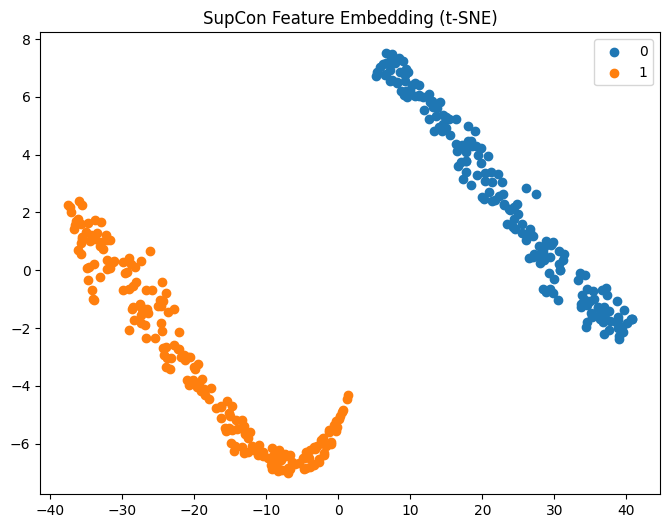

In [13]:
model.eval()
all_features, all_labels = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        features = model(x)
        all_features.append(features.cpu())
        all_labels.extend(y)

all_features = torch.cat(all_features).numpy()
all_labels = np.array(all_labels)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_features)

plt.figure(figsize=(8, 6))
for label in np.unique(all_labels):
    idxs = all_labels == label
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=str(label))
plt.legend()
plt.title("SupCon Feature Embedding (t-SNE)")
plt.show()


# 分類訓練

In [16]:
# === 6. 分類模型（使用訓練好的 encoder）===
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder  # 預訓練好的 encoder（可選擇是否凍結）
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        return self.classifier(x)

In [17]:
# === 9. 微調分類器 ===
print("\n=== Fine-tuning Classifier ===")

# 初始化分類器，使用 encoder 的 feature extractor（不包含 projection head）
frozen_encoder = model.encoder
num_classes = len(set(y_list))
classifier_model = Classifier(frozen_encoder, num_classes).to(device)

# 解凍 encoder 可選：取消 with torch.no_grad() → 再訓練 encoder
optimizer_cls = torch.optim.Adam(classifier_model.classifier.parameters(), lr=1e-3)
criterion_cls = nn.CrossEntropyLoss()

classifier_model.train()
for epoch in range(10):
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = classifier_model(x)
        loss = criterion_cls(logits, y)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(f"[CLS] Epoch {epoch} | Loss: {loss.item():.4f} | Acc: {acc:.2%}")



=== Fine-tuning Classifier ===
[CLS] Epoch 0 | Loss: 0.6821 | Acc: 68.32%
[CLS] Epoch 1 | Loss: 0.6709 | Acc: 99.74%
[CLS] Epoch 2 | Loss: 0.6620 | Acc: 100.00%
[CLS] Epoch 3 | Loss: 0.6507 | Acc: 99.48%
[CLS] Epoch 4 | Loss: 0.6401 | Acc: 99.74%
[CLS] Epoch 5 | Loss: 0.6350 | Acc: 99.48%
[CLS] Epoch 6 | Loss: 0.6227 | Acc: 99.21%
[CLS] Epoch 7 | Loss: 0.6224 | Acc: 99.21%
[CLS] Epoch 8 | Loss: 0.6082 | Acc: 99.48%
[CLS] Epoch 9 | Loss: 0.5930 | Acc: 99.48%
